<h1 style="text-align: center;">Electricity price forecasting by Elmy Centré</h1>

**Data description**

**Index**

**DELIVERY_START** : date et heure de livraison de l'électricité

**Variables explicatives**

**load_forecast** : prévision de consommation totale d'éléctricité en France

**coal_power_available**, **gas_power_available**, **nucelear_power_available** : capacité de production totale d'électricité des centrales à charbon, gaz et nucléaire respectivement,

**wind_power_forecasts_average**, **solar_power_forecasts_average** : moyenne de différentes prévisions de production totale d'électricité éolienne et solaire (respectivement),

**wind_power_forecasts_std**, **solar_power_forecasts_std** : écart-type de ces mêmes prévisions,

**predicted_spot_price** : prévision du prix SPOT de l'électricité issues d'un modèle interne de Elmy. Ce modèle est lancé chaque jour avant la fermeture des enchères SPOT pour le lendemain.


**Variable cible**

**spot_id_delta** : l'écart entre le VWAP des transactions sur le marché infra-journalier (Intraday) et le prix SPOT pour 1MWh d'électricité **(spot_id_delta = Intraday - SPOT)** : si la valeur est positive, le prix Intraday est supérieur au prix SPOT et inversement.

In [ ]:
#Instalattion des packages
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install missingno
!pip install matplotlib
!pip install scikit-learn
!pip install statsmodels
!pip install xgboost

In [4]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [1]:
#Importation des libraries
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_regression

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error, r2_score

__Importation des bases de données__

In [106]:
# Charger le fichier CSV dans un DataFrame
X_dt = pd.read_csv("X_train.csv",sep=",")
Y_dt = pd.read_csv("y_train.csv",sep=",")
X_test = pd.read_csv("X_test.csv",sep=",")

In [4]:
Y_dt

,DELIVERY_START,spot_id_delta
0,2022-01-01 02:00:00+01:00,-36.874770
1,2022-01-01 03:00:00+01:00,-12.643588
2,2022-01-01 04:00:00+01:00,-1.950193
3,2022-01-01 05:00:00+01:00,1.938272
4,2022-01-01 06:00:00+01:00,0.199907
...,...,...
10600,2023-03-29 19:00:00+02:00,6.029303
10601,2023-03-29 20:00:00+02:00,13.576177
10602,2023-03-29 21:00:00+02:00,17.478945
10603,2023-03-29 22:00:00+02:00,17.559407


In [5]:
X_dt

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
0,2022-01-01 02:00:00+01:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.000000,NaN
1,2022-01-01 03:00:00+01:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.000000,NaN
2,2022-01-01 04:00:00+01:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.000000,NaN
3,2022-01-01 05:00:00+01:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.000000,NaN
4,2022-01-01 06:00:00+01:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...
10600,2023-03-29 19:00:00+02:00,50814.0,3386.0,11952.0,38320.0,7552.0,651.0,247.408490,7.821622,108.11
10601,2023-03-29 20:00:00+02:00,50628.0,3386.0,11952.0,38320.0,8338.0,109.0,155.795012,2.534054,125.66
10602,2023-03-29 21:00:00+02:00,48201.0,3386.0,11952.0,38320.0,9115.0,0.0,126.884684,0.000000,138.01
10603,2023-03-29 22:00:00+02:00,47967.0,3386.0,11952.0,38320.0,9636.0,0.0,156.669189,0.000000,136.74


In [218]:
data_merge = pd.merge(Y_dt, X_dt, on="DELIVERY_START")
data_merge.sort_values(['DELIVERY_START'],inplace=True)

notre variable contient 10605 variables

In [9]:
data_merge.head()

,DELIVERY_START,spot_id_delta,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
0,2022-01-01 01:00:00+00:00,-36.874770,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.0,NaN
1,2022-01-01 02:00:00+00:00,-12.643588,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.0,NaN
2,2022-01-01 03:00:00+00:00,-1.950193,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.0,NaN
3,2022-01-01 04:00:00+00:00,1.938272,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.0,NaN
4,2022-01-01 05:00:00+00:00,0.199907,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.0,NaN


In [6]:
data_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10605 entries, 0 to 10604
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   DELIVERY_START                 10605 non-null  datetime64[ns, UTC]
 1   spot_id_delta                  10605 non-null  float64            
 2   load_forecast                  9318 non-null   float64            
 3   coal_power_available           10604 non-null  float64            
 4   gas_power_available            10604 non-null  float64            
 5   nucelear_power_available       10604 non-null  float64            
 6   wind_power_forecasts_average   10581 non-null  float64            
 7   solar_power_forecasts_average  10581 non-null  float64            
 8   wind_power_forecasts_std       10581 non-null  float64            
 9   solar_power_forecasts_std      10581 non-null  float64            
 10  predicted_spot_price  

__Verification des valeurs manquantes et leur gestion__

In [9]:
round((data_merge.isna().sum()/len(data_merge))*100,2)

DELIVERY_START                    0.00
spot_id_delta                     0.00
load_forecast                    12.14
coal_power_available              0.01
gas_power_available               0.01
nucelear_power_available          0.01
wind_power_forecasts_average      0.23
solar_power_forecasts_average     0.23
wind_power_forecasts_std          0.23
solar_power_forecasts_std         0.23
predicted_spot_price             82.59
dtype: float64

<Axes: >

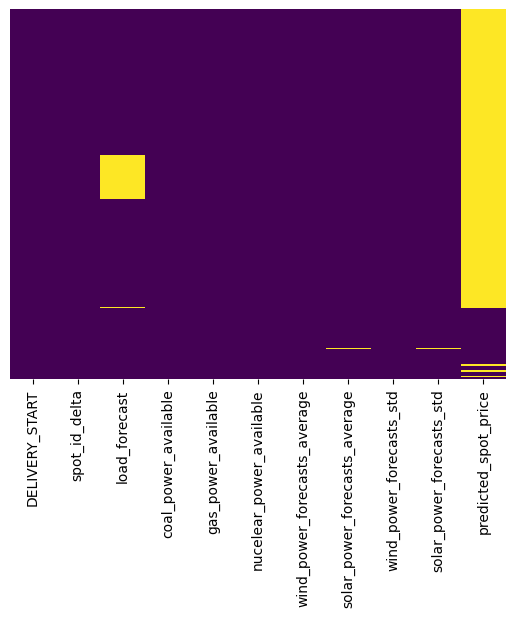

In [10]:
sns.heatmap(data_merge.isnull(),yticklabels=False, cbar=False,cmap='viridis')

In [219]:
# Convertir la colonne DELIVERY_START en format datetime en utilisant utc=True
data_merge['DELIVERY_START'] = pd.to_datetime(data_merge['DELIVERY_START'], utc=True)

C:\Users\boric\AppData\Local\Temp\ipykernel_19728\1427152886.py:3: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data_merge['DELIVERY_START'] = pd.to_datetime(data_merge['DELIVERY_START'], utc=False)


__Traitement des valeurs manquantes__

In [109]:
# Créer un imputer IterativeImputer
imputer = IterativeImputer(max_iter=10, random_state=0, sample_posterior=True)

# Sélectionner les colonnes à imputer
columns_to_impute = ['wind_power_forecasts_average',
                                                   'solar_power_forecasts_average','wind_power_forecasts_std',
                                                   'solar_power_forecasts_std','coal_power_available','gas_power_available','nucelear_power_available']
# Imputer les colonnes spécifiées
data_merge[columns_to_impute] = imputer.fit_transform(data_merge[columns_to_impute])

In [110]:
# Création des nouvelles variables temporelles
data_merge['hour'] = data_merge['DELIVERY_START'].dt.hour
data_merge['day_of_week'] = data_merge['DELIVERY_START'].dt.dayofweek
data_merge['month'] = data_merge['DELIVERY_START'].dt.month

# Création de la variable "jour ouvré"
data_merge['is_workday'] = data_merge['day_of_week'].apply(lambda x: 1 if x < 5 else 0)


#spot_id_delta = Y
# Création des retards et des moyennes glissantes
data_merge['Y_lag_1'] = data_merge['spot_id_delta'].shift(1)
data_merge['Y_rolling_mean_3'] = data_merge['spot_id_delta'].rolling(window=3).mean()
data_merge['Y_rolling_std_3'] = data_merge['spot_id_delta'].rolling(window=3).std()


# Remplacer les valeurs manquantes uniquement dans les colonnes des retards et moyennes glissantes
data_merge[['Y_lag_1', 'Y_rolling_mean_3', 'Y_rolling_std_3']] = data_merge[['Y_lag_1', 'Y_rolling_mean_3', 'Y_rolling_std_3']].fillna(0)

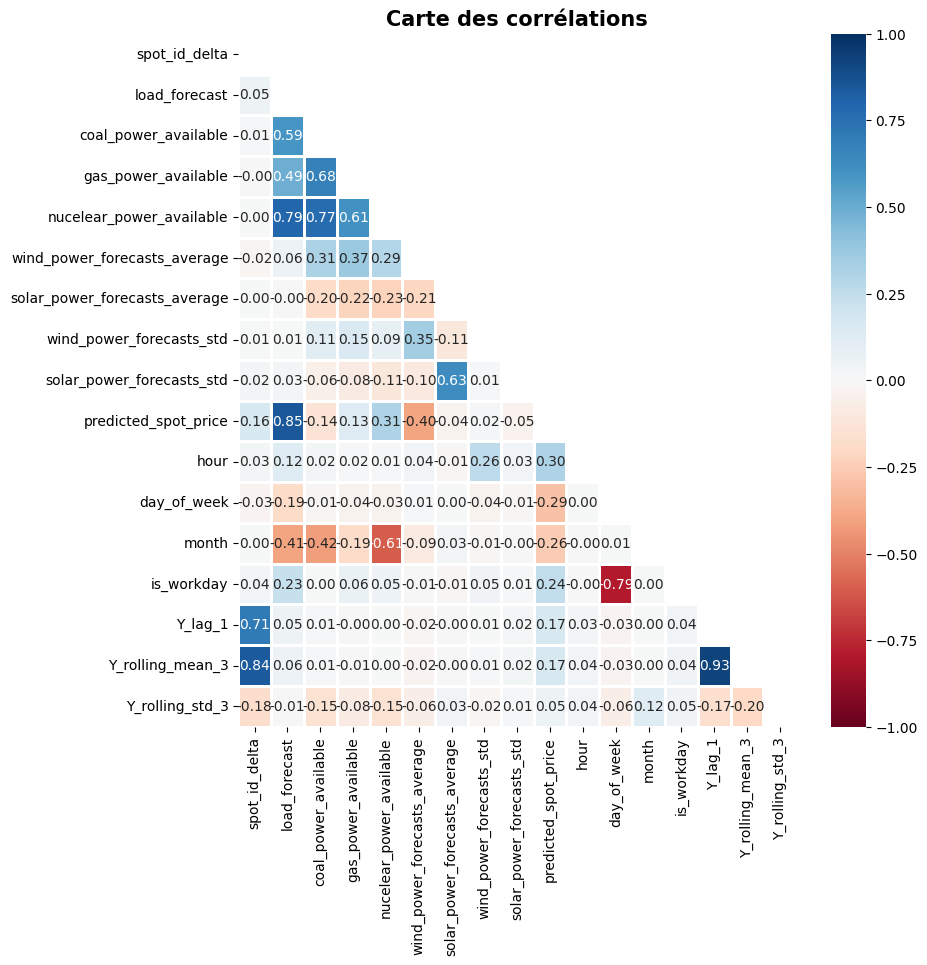

In [66]:
# Carte des corrélations

plt.figure(figsize=(9,9))

mask = np.triu(np.ones_like(data_merge.iloc[:, 1:].corr(), dtype=bool))

sns.heatmap(data_merge.iloc[:, 1:].corr(), 
            mask=mask, center=0, cmap='RdBu', linewidths=1, 
            annot=True, fmt=".2f", vmin=-1, vmax=1
)

plt.title('Carte des corrélations', fontsize=15, fontweight="bold")

plt.show()

In [111]:
# Initialisation du seed
seed = 123

# Fonction pour créer les modèles avec paramètres ajustables
def create_models(params=None):
    # Par défaut, les paramètres seront définis pour chaque modèle si non spécifiés
    if params is None:
        params = {
            'LR': {},
            'LASSO': {'alpha': 1.0},
            'EN': {'alpha': 1.0, 'l1_ratio': 0.5},
            'KNN': {'n_neighbors': 5},
            'CART': {'random_state': seed},
            'SVR': {},
            'MLP': {'random_state': seed, 'max_iter': 2000, 'learning_rate_init': 0.001},
            'ABR': {'random_state': seed},
            'XGBOOST': {'random_state': seed},
            'GBR': {'random_state': seed},
            'RFR': {'random_state': seed},
            'ETR': {'random_state': seed}
        }

    # Création du dictionnaire de modèles avec paramètres
    models = {
        'LR': LinearRegression(**params['LR']),
        'LASSO': Lasso(**params['LASSO']),
        'EN': ElasticNet(**params['EN']),
        'KNN': KNeighborsRegressor(**params['KNN']),
        'CART': DecisionTreeRegressor(**params['CART']),
        'SVR': SVR(**params['SVR']),
        'MLP': MLPRegressor(**params['MLP']),
        'ABR': AdaBoostRegressor(**params['ABR']),
        'XGBOOST': XGBRegressor(**params['XGBOOST']),
        'GBR': GradientBoostingRegressor(**params['GBR']),
        'RFR': RandomForestRegressor(**params['RFR']),
        'ETR': ExtraTreesRegressor(**params['ETR'])
    }
    return models

# Fonction d'évaluation des modèles
def evaluate_models(models, X_train, Y_train, X_test, Y_test, num_folds=5):
    scoring = 'neg_mean_squared_error'
    results = {}

    for model_name, model in models.items():
        kfold = KFold(n_splits=num_folds)

        # Calcul des scores de validation croisée
        cv_results = np.sqrt(-1 * cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring))

        # Ajustement du modèle
        fitted_model = model.fit(X_train, Y_train)

        # Calcul des métriques
        results[model_name] = {
            'model': fitted_model,
            'RMSE train': np.sqrt(mean_squared_error(Y_train, fitted_model.predict(X_train))),
            'RMSE test': np.sqrt(mean_squared_error(Y_test, fitted_model.predict(X_test))),
            'Mean CV results': cv_results.mean(),
            'Std CV results': cv_results.std(),
            'R² train': r2_score(Y_train, fitted_model.predict(X_train)),
            'R² test': r2_score(Y_test, fitted_model.predict(X_test))
        }

    return pd.DataFrame.from_dict(results, orient='index')

# La variable load_forecast

In [112]:
data_loadf = data_merge.dropna(subset=['load_forecast'])
data_loadf=data_loadf.drop(columns=['predicted_spot_price'])
round((data_loadf.isna().sum()/len(data_loadf))*100,2)

DELIVERY_START                   0.0
spot_id_delta                    0.0
load_forecast                    0.0
coal_power_available             0.0
gas_power_available              0.0
nucelear_power_available         0.0
wind_power_forecasts_average     0.0
solar_power_forecasts_average    0.0
wind_power_forecasts_std         0.0
solar_power_forecasts_std        0.0
hour                             0.0
day_of_week                      0.0
month                            0.0
is_workday                       0.0
Y_lag_1                          0.0
Y_rolling_mean_3                 0.0
Y_rolling_std_3                  0.0
dtype: float64

In [113]:
# Séparer la variable cible et les variables explicatives
X_loadf_train = data_loadf.drop(columns=['load_forecast', 'DELIVERY_START'])
y_loadf_train = data_loadf['load_forecast']

# Séparer les données d'entraînement et de test
Xlf_train, Xlf_test, ylf_train, ylf_test = train_test_split(X_loadf_train, y_loadf_train, test_size=0.1, random_state=42)


In [114]:
# Appliquer le scaler sur les données d'entraînement
Xlf_train = scaler.fit_transform(Xlf_train)

# Appliquer le même scaler sur les données de test
Xlf_test = scaler.transform(Xlf_test)

In [115]:
# Initialisation des paramètres
seed = 123
iter = 2000
lr = 0.001
mdl_lf= create_models()
# Évaluation des modèles
results_metrics_lf = evaluate_models(mdl_lf, Xlf_train, ylf_train, Xlf_test, ylf_test,num_folds=10)
results_metrics_lf


C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the 

,model,RMSE train,RMSE test,Mean CV results,Std CV results,R² train,R² test
LR,LinearRegression(),5794.695159,5881.399002,5810.950929,84.132727,0.737318,0.712642
LASSO,Lasso(),5794.699146,5881.374077,5810.882654,84.216167,0.737317,0.712644
EN,ElasticNet(),6649.585806,6607.893942,6658.672426,133.114251,0.654093,0.637266
KNN,KNeighborsRegressor(),2733.488375,3510.873746,3720.554254,167.554298,0.941547,0.897602
CART,DecisionTreeRegressor(random_state=123),0.000000,2980.543605,3254.708905,178.286492,1.000000,0.926201
SVR,SVR(),11093.190787,10839.203057,11127.808406,317.107287,0.037318,0.023984
MLP,"MLPRegressor(max_iter=2000, random_state=123)",5254.211104,5408.003847,5411.905414,138.028476,0.784034,0.757039
ABR,"(DecisionTreeRegressor(max_depth=3, random_sta...",5078.667575,5056.182191,5183.311707,92.418545,0.798224,0.787623
XGBOOST,"XGBRegressor(base_score=None, booster=None, ca...",842.546588,1684.925629,1764.358613,79.058659,0.994447,0.976416
GBR,([DecisionTreeRegressor(criterion='friedman_ms...,3530.922033,3709.609101,3663.250993,107.802094,0.902468,0.885681


<Axes: >

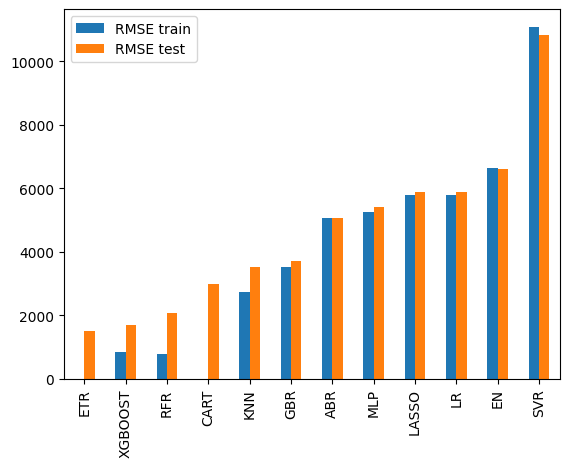

In [116]:
# Affichage des résultats
with pd.option_context('display.precision', 3):
    best_printlf = results_metrics_lf.sort_values(by='RMSE test', ascending=True)

# Comparaison des erreurs d'entraînement et de test
best_printlf[['RMSE train', 'RMSE test']].plot(kind='bar')

In [117]:
best_mdlf=results_metrics_lf.loc['RFR', 'model']

In [119]:
#la base avec les valeurs manquantes 
data_lf_with_na = data_merge[data_merge['load_forecast'].isna()]

#definir les valeurs pour la prediction
Xlf_predi= data_lf_with_na.drop(columns=['DELIVERY_START', 'load_forecast','predicted_spot_price'])

In [120]:
# Remplir les valeurs manquantes dans le DataFrame d'origine
data_merge.loc[data_merge['load_forecast'].isna(), 'load_forecast'] =best_mdlf.predict(Xlf_predi)

C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


# Traitement de la variable predicted_spot_price

In [121]:
data_predspot = data_merge.dropna(subset=['predicted_spot_price'])

round((data_predspot.isna().sum()/len(data_predspot))*100,2)

DELIVERY_START                   0.0
spot_id_delta                    0.0
load_forecast                    0.0
coal_power_available             0.0
gas_power_available              0.0
nucelear_power_available         0.0
wind_power_forecasts_average     0.0
solar_power_forecasts_average    0.0
wind_power_forecasts_std         0.0
solar_power_forecasts_std        0.0
predicted_spot_price             0.0
hour                             0.0
day_of_week                      0.0
month                            0.0
is_workday                       0.0
Y_lag_1                          0.0
Y_rolling_mean_3                 0.0
Y_rolling_std_3                  0.0
dtype: float64

In [122]:
# Séparer la variable cible et les variables explicatives
X_Spot_price_train = data_predspot.drop(columns=['predicted_spot_price', 'DELIVERY_START'])
y_Spot_price_train = data_predspot['predicted_spot_price']

# Séparer les données d'entraînement et de test
Xsp_train, Xsp_test, ysp_train, ysp_test = train_test_split(X_Spot_price_train, y_Spot_price_train, test_size=0.1, random_state=42)

In [123]:
#Standadiser
# Initialisation du scaler
scaler = StandardScaler()

# Appliquer le scaler sur les données d'entraînement
Xsp_train = scaler.fit_transform(Xsp_train)

# Appliquer le même scaler sur les données de test
Xsp_test = scaler.transform(Xsp_test)

In [124]:
# Initialisation des paramètres
seed = 123
iter = 2000
lr = 0.001

# Création des modèles
model_sp = create_models()

# Évaluation des modèles
results_metrics_sp = evaluate_models(model_sp, Xsp_train, ysp_train, Xsp_test, ysp_test,num_folds=10)
results_metrics_sp

C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the 

,model,RMSE train,RMSE test,Mean CV results,Std CV results,R² train,R² test
LR,LinearRegression(),1.495299e+01,15.183937,15.048787,0.935501,0.802267,0.825556
LASSO,Lasso(),1.533806e+01,15.524058,15.357105,1.084997,0.791952,0.817653
EN,ElasticNet(),1.797946e+01,19.046188,18.000429,1.497364,0.714125,0.725525
KNN,KNeighborsRegressor(),1.064765e+01,15.087117,14.215181,0.943188,0.899739,0.827774
CART,DecisionTreeRegressor(random_state=123),0.000000e+00,15.045012,14.732869,1.273533,1.000000,0.828734
SVR,SVR(),1.968450e+01,21.187408,20.441142,1.534513,0.657333,0.660341
MLP,"MLPRegressor(max_iter=2000, random_state=123)",6.709198e+00,9.286223,10.001123,0.520001,0.960193,0.934752
ABR,"(DecisionTreeRegressor(max_depth=3, random_sta...",1.347169e+01,14.985034,14.352583,0.876075,0.839503,0.830096
XGBOOST,"XGBRegressor(base_score=None, booster=None, ca...",7.014862e-01,7.745315,7.814145,0.394075,0.999565,0.954609
GBR,([DecisionTreeRegressor(criterion='friedman_ms...,7.792328e+00,9.782168,9.478186,0.683234,0.946302,0.927597


<Axes: >

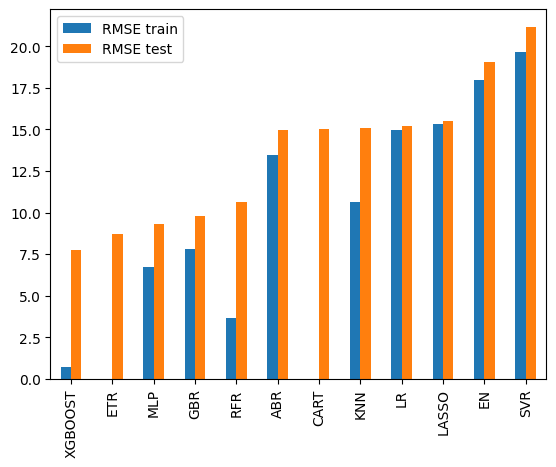

In [125]:
# Affichage des résultats
with pd.option_context('display.precision', 3):
    best_print_sp = results_metrics_sp.sort_values(by='RMSE test', ascending=True)

# Comparaison des erreurs d'entraînement et de test
best_print_sp[['RMSE train', 'RMSE test']].plot(kind='bar')

In [126]:
#Choix du modèle
best_mdsp=results_metrics_sp.loc['GBR', 'model']

In [127]:
#la base avec les valeurs manquantes 
data_sp_with_na = data_merge[data_merge['predicted_spot_price'].isna()]

#definir les valeurs pour la prediction
Xsp_predi= data_sp_with_na.drop(columns=['DELIVERY_START','predicted_spot_price'])

In [128]:
# Remplir les valeurs manquantes dans le DataFrame d'origine
data_merge.loc[data_merge['predicted_spot_price'].isna(), 'predicted_spot_price'] =best_mdsp.predict(Xsp_predi)

C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


In [129]:
round((data_merge.isna().sum()/len(data_merge))*100,2)

DELIVERY_START                   0.0
spot_id_delta                    0.0
load_forecast                    0.0
coal_power_available             0.0
gas_power_available              0.0
nucelear_power_available         0.0
wind_power_forecasts_average     0.0
solar_power_forecasts_average    0.0
wind_power_forecasts_std         0.0
solar_power_forecasts_std        0.0
predicted_spot_price             0.0
hour                             0.0
day_of_week                      0.0
month                            0.0
is_workday                       0.0
Y_lag_1                          0.0
Y_rolling_mean_3                 0.0
Y_rolling_std_3                  0.0
dtype: float64

# la variable spot_id_delta

In [130]:
# Séparer la variable cible et les variables explicatives
X_Spot_delta_train = data_merge.drop(columns=['spot_id_delta', 'DELIVERY_START'])
y_Spot_delta_train = data_merge['spot_id_delta']

# Séparer les données d'entraînement et de test
Xdel_train, Xdel_test, ydel_train, ydel_test = train_test_split(X_Spot_delta_train, y_Spot_delta_train, test_size=0.1, random_state=42)

In [131]:
#Standadiser
# Initialisation du scaler
scaler = StandardScaler()

# Appliquer le scaler sur les données d'entraînement
Xdel_train = scaler.fit_transform(Xdel_train)

# Appliquer le même scaler sur les données de test
Xdel_test = scaler.transform(Xdel_test)

# Exemple d'utilisation
params = {
    'LR': {},  # Modèle par défaut
    'LASSO': {'alpha': 0.5},  # Ajuster l'alpha pour Lasso
    'EN': {'alpha': 0.1, 'l1_ratio': 0.7},  # Paramètres pour ElasticNet
    'MLP': {'random_state': seed, 'max_iter': 3000, 'learning_rate_init': 0.01}  # Paramètres pour MLP
}

In [132]:
# Création des modèles avec les paramètres définis
model_del = create_models()

# Évaluation des modèles
results_metric_del = evaluate_models(model_del, Xdel_train, ydel_train, Xdel_test, ydel_test,num_folds=10)
results_metric_del


,model,RMSE train,RMSE test,Mean CV results,Std CV results,R² train,R² test
LR,LinearRegression(),2.005795e+01,13.251533,19.858746,13.948822,0.730118,0.839195
LASSO,Lasso(),2.075212e+01,13.403083,19.450812,12.013490,0.711115,0.835496
EN,ElasticNet(),2.406641e+01,18.126772,22.305431,11.087839,0.611472,0.699110
KNN,KNeighborsRegressor(),2.257956e+01,16.976380,23.580549,13.857786,0.657996,0.736089
CART,DecisionTreeRegressor(random_state=123),0.000000e+00,20.522834,26.820843,18.037503,1.000000,0.614307
SVR,SVR(),3.026572e+01,22.251267,27.228325,13.728329,0.385528,0.546605
MLP,"MLPRegressor(max_iter=2000, random_state=123)",1.904500e+01,13.188623,23.192137,20.662286,0.756689,0.840718
ABR,"(DecisionTreeRegressor(max_depth=3, random_sta...",1.821057e+01,19.186641,27.436366,16.124084,0.777542,0.662895
XGBOOST,"XGBRegressor(base_score=None, booster=None, ca...",4.122789e+00,12.273342,22.705078,13.679745,0.988598,0.862059
GBR,([DecisionTreeRegressor(criterion='friedman_ms...,1.018467e+01,12.746474,21.856635,14.702238,0.930418,0.851219


<Axes: >

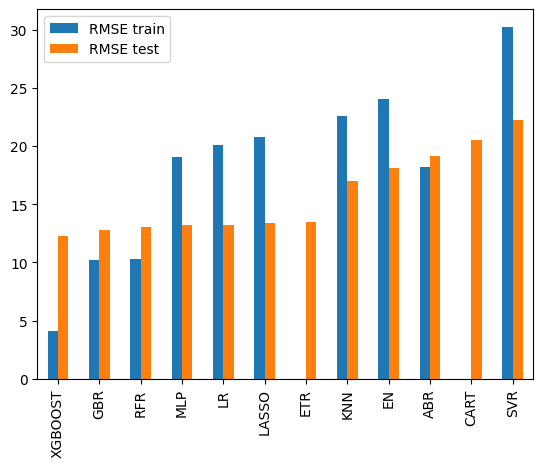

In [133]:
# Affichage des résultats
with pd.option_context('display.precision', 3):
    best_print_del = results_metric_del.sort_values(by='RMSE test', ascending=True)

# Comparaison des erreurs d'entraînement et de test
best_print_del[['RMSE train', 'RMSE test']].plot(kind='bar')

In [134]:
# Appel du meilleur modèle
best_model_del = results_metric_del.loc['GBR', 'model']  # Exemple : MLP comme meilleur modèle
# Prédiction avec le meilleur modèle sur de nouvelles données
#y_pred = best_model.predict(X_new)

# Traitement de la base X_test

In [201]:
dt_test = pd.read_csv("X_test.csv",sep=",")
X_test=dt_test

In [202]:
X_test['DELIVERY_START'] = pd.to_datetime(X_test['DELIVERY_START'])
# Création des nouvelles variables temporelles
X_test['hour'] = X_test['DELIVERY_START'].dt.hour
X_test['day_of_week'] = X_test['DELIVERY_START'].dt.dayofweek
X_test['month'] = X_test['DELIVERY_START'].dt.month

# Création de la variable "jour ouvré"
X_test['is_workday'] = X_test['day_of_week'].apply(lambda x: 1 if x < 5 else 0)


#spot_id_delta = Y
# Création des retards et des moyennes glissantes
X_test['Y_lag_1'] = X_test['load_forecast'].shift(1)
X_test['Y_rolling_mean_3'] = X_test['load_forecast'].rolling(window=3).mean()
X_test['Y_rolling_std_3'] = X_test['load_forecast'].rolling(window=3).std()


# Remplacer les valeurs manquantes uniquement dans les colonnes des retards et moyennes glissantes
X_test[['Y_lag_1', 'Y_rolling_mean_3', 'Y_rolling_std_3']] = X_test[['Y_lag_1', 'Y_rolling_mean_3', 'Y_rolling_std_3']].fillna(0)

In [204]:
# Sélectionner les colonnes à imputer
columns_to_impute_test = ['solar_power_forecasts_average','solar_power_forecasts_std']
# Imputer les colonnes spécifiées
X_test[columns_to_impute_test] = imputer.fit_transform(X_test[columns_to_impute_test])

In [205]:
data_predspot_test = X_test.dropna(subset=['predicted_spot_price'])

In [206]:
# Séparer la variable cible et les variables explicatives
X_Spot_test_train = data_predspot_test.drop(columns=['predicted_spot_price', 'DELIVERY_START'])
y_Spot_test_train = data_predspot_test['predicted_spot_price']

# Séparer les données d'entraînement et de test
Xsptest_train, Xsptest_test, ysptest_train, ysptest_test = train_test_split(X_Spot_test_train, y_Spot_test_train, test_size=0.1, random_state=42)

In [207]:
#Standadiser

# Appliquer le scaler sur les données d'entraînement
Xsptest_train = scaler.fit_transform(Xsptest_train)

# Appliquer le même scaler sur les données de test
Xsptest_test = scaler.transform(Xsptest_test)

In [208]:
# Création des modèles
model_sp_test = create_models()

# Évaluation des modèles
results_metrics_sp_test = evaluate_models(model_sp_test, Xsptest_train, ysptest_train, Xsptest_test, ysptest_test,num_folds=10)
results_metrics_sp_test

C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the 

,model,RMSE train,RMSE test,Mean CV results,Std CV results,R² train,R² test
LR,LinearRegression(),1.831369e+01,18.840768,18.430728,0.722278,0.584572,0.578393
LASSO,Lasso(),1.866031e+01,18.857791,18.728787,0.797286,0.568697,0.577630
EN,ElasticNet(),2.025293e+01,20.128243,20.302938,0.828668,0.491934,0.518803
KNN,KNeighborsRegressor(),1.005023e+01,12.624762,13.206357,0.733102,0.874889,0.810697
CART,DecisionTreeRegressor(random_state=123),0.000000e+00,15.505143,17.017308,0.893434,1.000000,0.714463
SVR,SVR(),1.749646e+01,18.605473,18.033619,0.845194,0.620820,0.588857
MLP,"MLPRegressor(max_iter=2000, random_state=123)",7.814966e+00,10.888129,10.181416,0.449428,0.924352,0.859195
ABR,"(DecisionTreeRegressor(max_depth=3, random_sta...",1.533961e+01,17.084519,16.220210,0.529459,0.708544,0.653330
XGBOOST,"XGBRegressor(base_score=None, booster=None, ca...",1.967955e+00,7.893984,8.287807,0.439331,0.995203,0.925988
GBR,([DecisionTreeRegressor(criterion='friedman_ms...,1.026184e+01,11.952884,11.782084,0.453086,0.869565,0.830310


<Axes: >

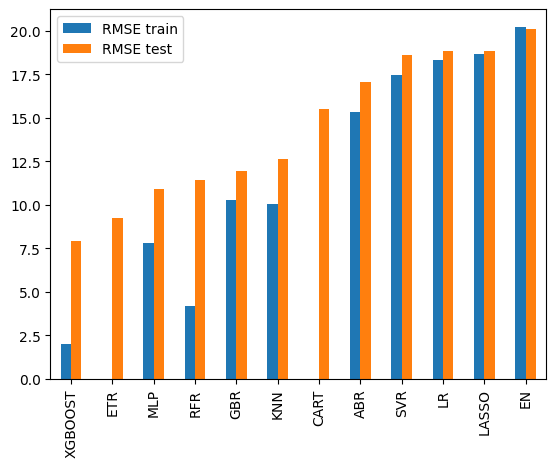

In [209]:
# Affichage des résultats
with pd.option_context('display.precision', 3):
    best_print_sp_test = results_metrics_sp_test.sort_values(by='RMSE test', ascending=True)

# Comparaison des erreurs d'entraînement et de test
best_print_sp_test[['RMSE train', 'RMSE test']].plot(kind='bar')

In [210]:
# Appel du meilleur modèle
best_model_sp_test = results_metrics_sp_test.loc['MLP', 'model'] 

In [211]:
#la base avec les valeurs manquantes 
data_sp_test_with_na = X_test[X_test['predicted_spot_price'].isna()]

#definir les valeurs pour la prediction
Xsp_test_predi= data_sp_test_with_na.drop(columns=['DELIVERY_START','predicted_spot_price'])

In [213]:
# Remplir les valeurs manquantes dans le DataFrame d'origine
X_test.loc[X_test['predicted_spot_price'].isna(), 'predicted_spot_price'] =best_model_sp_test.predict(Xsp_test_predi)

C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


In [214]:
y_test_pred=best_model_del.predict(X_test.drop(columns=['DELIVERY_START']))
resultat_test = pd.DataFrame({
    'DELIVERY_START': X_test['DELIVERY_START'],  # Assuming this column exists
    'spot_id_delta': y_test_pred
})

C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


In [215]:
resultat_test.head(10)

,DELIVERY_START,spot_id_delta
0,2023-04-02 00:00:00+02:00,2.013607
1,2023-04-02 01:00:00+02:00,-63.545014
2,2023-04-02 02:00:00+02:00,162.231603
3,2023-04-02 03:00:00+02:00,162.231603
4,2023-04-02 04:00:00+02:00,162.231603
5,2023-04-02 05:00:00+02:00,162.231603
6,2023-04-02 06:00:00+02:00,162.231603
7,2023-04-02 07:00:00+02:00,158.227044
8,2023-04-02 08:00:00+02:00,152.494813
9,2023-04-02 09:00:00+02:00,152.494813


In [217]:
#Save the results to a CSV file
resultat_test.to_csv('delivery_start_with.csv', index=False)

In [212]:
X_test.head(10)

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,hour,day_of_week,month,is_workday,Y_lag_1,Y_rolling_mean_3,Y_rolling_std_3
0,2023-04-02 00:00:00+02:00,45814.0,3386.0,10902.0,36705.0,6359.0,0.0,56.764535,0.000000,NaN,0,6,4,0,0.0,0.000000,0.000000
1,2023-04-02 01:00:00+02:00,44084.0,3386.0,10902.0,36705.0,6469.0,0.0,54.262133,0.000000,NaN,1,6,4,0,45814.0,0.000000,0.000000
2,2023-04-02 02:00:00+02:00,43281.0,3386.0,10902.0,36705.0,6511.0,0.0,78.105928,0.000000,NaN,2,6,4,0,44084.0,44393.000000,1294.462437
3,2023-04-02 03:00:00+02:00,40825.0,3386.0,10902.0,36705.0,6628.0,0.0,78.187557,0.000000,NaN,3,6,4,0,43281.0,42730.000000,1697.931388
4,2023-04-02 04:00:00+02:00,39181.0,3386.0,10902.0,36705.0,6700.0,0.0,96.765484,0.000000,NaN,4,6,4,0,40825.0,41095.666667,2063.357781
5,2023-04-02 05:00:00+02:00,38928.0,3386.0,10902.0,36705.0,6750.0,0.0,133.267741,0.000000,NaN,5,6,4,0,39181.0,39644.666667,1029.996278
6,2023-04-02 06:00:00+02:00,39181.0,3386.0,10902.0,36705.0,6808.0,0.0,148.852429,0.000000,NaN,6,6,4,0,38928.0,39096.666667,146.069618
7,2023-04-02 07:00:00+02:00,40070.0,3386.0,10902.0,36705.0,6816.0,76.0,194.708606,1.150447,NaN,7,6,4,0,39181.0,39393.000000,599.790797
8,2023-04-02 08:00:00+02:00,41653.0,3386.0,10902.0,36705.0,6798.0,806.0,262.002351,6.050982,NaN,8,6,4,0,40070.0,40301.333333,1252.131117
9,2023-04-02 09:00:00+02:00,44137.0,3386.0,10902.0,36705.0,6933.0,2404.0,274.430105,47.362046,NaN,9,6,4,0,41653.0,41953.333333,2050.066422
